"""SST simulator case type II.

    Basic simulator of an organization of Stand By, stabilization 
    and transport of a cryonic case.
    Where the system (SST) is composed of:
    + a subject (patient)
    + three agents (doctor, thanatopractician, ambulance)
    + a variable set of time ranges.
    The objective is to simulate a set of cases to extract the 
    average and statistics to decide how to improve a 
    cryonic suspension procedure.
    
    NOTE: This is non ideal case, at home, out of hospital. 
    It means if this is a patient election it's very importante
    make other type of arrangements. 

"""

In [1]:
# Imports
import simpy
import random
import statistics
from colorama import init
from termcolor import colored
import matplotlib.pyplot as plt

In [2]:
# Variables
wait_times = []
population = 25 # Population based in detach range who can't be in a hospital.

"""SST.

    SST = Stand By, Stabilization, Transport
    Embalmer = thanatopractitioner
    Medico = dispensing death certificate and embalming
    Stand By = metabolic support and hypothermia of the patient, 
    manual (voluntary) or mechanical (ECMO, LUCA)
    Stabilisation = controlled perfusion of cryoprotective fluids, 
    following IC protocol and formulas for reasons of economy.

    This class instantiates the environment with its constituent 
    agents to iterate their actions with varying times, simulate good and bad times, 
    collect them and make a statistic of the average time. 

    Allowing to make simulations ahead of any practice and 
    thus reduce incidences or hazards for the patient.

"""

In [3]:
class Sst(object):
    # Environment
    def __init__(self, env, agent_embalmer, agent_doctor, agent_ambulance, agent_place):
        self.env = env
        self.embalmer = simpy.Resource(env, agent_embalmer)
        self.doctor = simpy.Resource(env, agent_doctor)
        self.ambulance = simpy.Resource(env, agent_ambulance)
        self.place = simpy.Resource(env, agent_place)

    def death_authorization(self, patient):
        # Remember: timeout is limited to 12 hours
        yield self.env.timeout(random.randint(1, 6))

    def embalming_authorization(self, patient):
        yield self.env.timeout(random.randint(1, 6))

    def stand_by(self, patient):
        # No more than 1h support
        yield self.env.timeout(random.randint(0, 1))
    
    def perfusion(self, patient):
        # Time is optimizing for only head perfusion.
        yield self.env.timeout(random.randint(0, 1))

"""Deanimation.

    State of legal death of patiente.
    Call the variables and instance of environment, patient and SST.
    Simulate de arrivel, embalmer taking the death authorization, 
    embalming authorization and open option of start Stand By 
    under doctor control. Take the generated times by step.
    
    In resume: start the event of cryonics suspenson by deanimation
    and take the generated data with random factor times to generate
    all possible states of every case.
    
"""

In [4]:
def deanimation(env, patient, sst):
    # patient arrives at the Sst
    arrival_time = env.now

    if random.choice([True, False]): # Hypotetical case of extreme delay and simulate the doctor decision of
        with sst.doctor.request() as request: # apply stand by or straigh freeze.
            yield request
            yield env.process(sst.stand_by(patient))
            
    with sst.embalmer.request() as request:
        yield request
        yield env.process(sst.death_authorization(patient))

    with sst.ambulance.request() as request:
        yield request
        yield env.process(sst.embalming_authorization(patient))
    
    with sst.place.request() as request:
        # Means place to perfusion: hospital or funeral home or special ambulance.
        yield request
        yield env.process(sst.perfusion(patient))

    # patient heads into the Sst
    wait_times.append(env.now - arrival_time)

"""Run SST.

    Function who runs the procedure of execution environment.
    Take the constants and variables Environment, Embalmer,
    Doctor, ambulance.
    
    Launch one deanimation per patient.
    And generate another case after ending the last.
    For take enought data for statistics.

"""

In [5]:
def run_Sst(env, agent_embalmer, agent_doctor, agent_ambulance, agent_place, population):
    # Execute instantiation environment and get agents to simulate.
    sst = Sst(env, agent_embalmer, agent_doctor, agent_ambulance, agent_place)

    for patient in range(population): # Stimated population of active possible cryonicist in a country
        env.process(deanimation(env, patient, sst))
    
    while True:
        yield env.timeout(0.20)  # Wait a bit before generating a new patient in simulation.

        patient += 1
        env.process(deanimation(env, patient, sst))

"""Get average wait time.
    
    Function with procedure to generate the average time and 
    feed the result to show general average time of 
    suspension.
    
"""

In [6]:
def get_average_wait_time(wait_times):
    average_wait = statistics.mean(wait_times)
    # Pretty print the results
    minutes, frac_minutes = divmod(average_wait, 1)
    seconds = frac_minutes * 60
    return round(minutes), round(seconds)

In [7]:
def graph_and_statistics(wait_times):
    time_limit=[50]
    average_wait = statistics.mean(wait_times)
    mode_wait = statistics.mode(wait_times)
    median_wait = statistics.median(wait_times)
    print("Print mode times: ",mode_wait)
    print("Print median times: ",median_wait)
    print("Print wait times list: ",wait_times)
    print("Print average wait: ", round(average_wait),'red line')
    plt.axhline(round(average_wait), color="red")
    plt.bar(wait_times,wait_times)
    plt.title("global wait times per case")
    plt.ylabel('Max time: 100 hours')
    plt.xlabel('Sorted generated cases')
    plt.show()

"""Get user input.

    Function with procedure to control input
    of flow chart in environment.
    It is pre-configured to not interaction
    with user.
    
"""

In [8]:
def get_user_input():
    agent_embalmer = "1"
    agent_doctor = "1"
    agent_ambulance = "1"
    agent_place = "1"
    params = [agent_embalmer, agent_doctor, agent_ambulance, agent_place]
    if all(str(i).isdigit() for i in params):  # Check input is valid
        params = [int(x) for x in params]
    else:
        print(
            "Could not parse input. Simulation will use default values:",
            "\n1 embalmer, 1 doctor, 1 ambulance.",
        )
        params = ["1", "1", "1"]
    return params

"""Main.

    Main function launch and run all simulation, process and show the results.
    
    Next objectives:
    
     + Add param times ambulance.
     + Add individual times of doctor, embalmer, ambulance, wait time at funeral home, fly shipping.
     + Add readable and markdown color table he general and specific data.
     
"""

In [9]:
def main():
    # Setup
    random.seed(42)
    agent_embalmer, agent_doctor, agent_ambulance, agent_place = get_user_input()

    # Run the simulation
    env = simpy.Environment()
    env.process(run_Sst(env, agent_embalmer, agent_doctor, agent_ambulance, agent_place, population))
    env.run(until=90)
    # View the results
    hours, secs = get_average_wait_time(wait_times)
    print(colored(f"Based in stimated population in country: {population}","grey","on_blue"))
    print(
        "Running simulation...                \n"+
        "Protocol:                            \n"+
        "1º death authorization               \n"+
        "2º embalming authorization           \n"+
        "3º stand by                          \n"+
        "4º stabilization/perfusion           \n"+
        f"\nThe average wait time is {hours} hours."
    )
    graph_and_statistics(wait_times)

Based in stimated population in country: 25
Running simulation...                
Protocol:                            
1º death authorization               
2º embalming authorization           
3º stand by                          
4º stabilization/perfusion           

The average wait time is 46 hours.
Print mode times:  3
Print median times:  47.5
Print wait times list:  [3, 9, 11, 18, 21, 27, 33, 35, 42, 43.4, 45.0, 50, 54.8, 56.4, 59.0, 67, 67.8, 71, 73.4, 76.2, 85, 84.0]
Print average wait:  47 red line


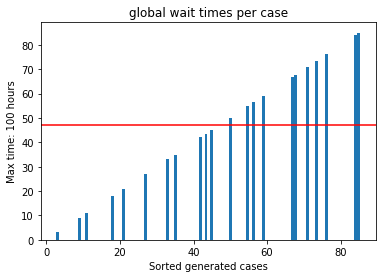

In [10]:
if __name__ == "__main__":
    main()

In [11]:
# Resources:
# https://github.com/realpython/materials/blob/master/simulation-with-simpy/simulate.py
# https://simpy.readthedocs.io/en/latest/
# https://www.cryonics.org/ci-landing/guide-to-cryonics-procedures/
# https://sociedadcrionica.org
# https://pypi.org/project/colorama/
# https://datatofish.com/bar-chart-python-matplotlib/
# http://matplotlib.1069221.n5.nabble.com/Bar-chart-line-chart-td12470.html

In [12]:
# Notes:
# Stimation of cryonicist population in Spain: 100, but between people who can't afford or delay cut by !/2.